<a href="https://colab.research.google.com/github/fidanaydamirova/education_gap/blob/main/education_gap_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the notebook

Install 

In [51]:
#pyspark
!pip install pyspark

#java virtual machine
!apt install openjdk-8-jdk-headless &> /dev/null

Import the necessary libraries.

In [52]:
import os

from pyspark.sql import SparkSession

from pyspark.sql.types import StructType, IntegerType, FloatType, StructField, StringType

from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml import Pipeline

from pyspark.sql.functions import isnan, when, count, col, avg, sum, round, stddev

import matplotlib.pyplot as plt

Set the java environmental variable

In [53]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

## Create a SparkSesssion

##### $\rightarrow$ Create a `SparkSession`.

In [54]:
spark = SparkSession.builder.master("local").getOrCreate()

Examine the `SparkSession`

In [55]:
spark

## Load data

##### $\rightarrow$ Load the `flights_small.csv` data set. This is similar to the data set used in Introduction to Pyspark on datacamp.

In [56]:
!wget https://raw.githubusercontent.com/goodboychan/datacamp_repo/master/Introduction.to.PySpark/dataset/flights_small.csv

--2021-12-14 05:55:12--  https://raw.githubusercontent.com/goodboychan/datacamp_repo/master/Introduction.to.PySpark/dataset/flights_small.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 614173 (600K) [text/plain]
Saving to: ‘flights_small.csv.1’

flights_small.csv.1 100%[===================>] 599.78K  --.-KB/s    in 0.04s   

2021-12-14 05:55:12 (13.5 MB/s) - ‘flights_small.csv.1’ saved [614173/614173]



##### $\rightarrow$ Read the data set into a Spark DataFrame called `df`.

We need to specify a few options here. We specify that the header of the data set contains the columns names, not data values. We also ask Spark to infer the data types for each column.

In [57]:
df = spark\
  .read\
  .option("inferSchema", "true")\
  .option("header", "true")\
  .csv("flights_small.csv")

##### $\rightarrow$ Use `show()` to display head of the DataFrame

In [58]:
df.show(5)

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA| LAX|     132|     954|   6|    58|
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|
|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA| SFO|     111|     679|  14|    43|
|2014|    4|  9|    1705|       45|    1839|       34|     WN| N360SW|   344|   PDX| SJC|      83|     569|  17|     5|
|2014|    3|  9|     754|       -1|    1015|        1|     AS| N612AS|   522|   SEA| BUR|     127|     937|   7|    54|
+----+-----+---+--------+---------+-----

##### $\rightarrow$ Print the size of the DataFrame.

In [59]:
print((df.count(), len(df.columns)))

(10000, 16)


##### $\rightarrow$ Check the data types to see how it infered the schema.

In [60]:
df.dtypes

[('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('dep_time', 'string'),
 ('dep_delay', 'string'),
 ('arr_time', 'string'),
 ('arr_delay', 'string'),
 ('carrier', 'string'),
 ('tailnum', 'string'),
 ('flight', 'int'),
 ('origin', 'string'),
 ('dest', 'string'),
 ('air_time', 'string'),
 ('distance', 'int'),
 ('hour', 'string'),
 ('minute', 'string')]

##### $\rightarrow$ This is incorrect, so we need to specify the schema explicitly.

In [61]:
schema = StructType([
    StructField('year', IntegerType()),
    StructField('month', IntegerType()),
    StructField('day', IntegerType()),
    StructField('dep_time', FloatType()),
    StructField('dep_delay', FloatType()),
    StructField('arr_time', FloatType()),
    StructField('arr_delay', FloatType()),
    StructField('carrier', StringType()),
    StructField('tailnum', StringType()),
    StructField('flight', IntegerType()),
    StructField('origin', StringType()),
    StructField('dest', StringType()),
    StructField('air_time', FloatType()),
    StructField('distance', IntegerType()),
    StructField('hour', IntegerType()),
    StructField('minute', IntegerType())])

##### $\rightarrow$ Reload the file using this schema and check the data types

In [62]:
df = spark\
  .read\
  .option("header", "true")\
  .schema(schema)\
  .csv("flights_small.csv")

In [63]:
df.dtypes

[('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('dep_time', 'float'),
 ('dep_delay', 'float'),
 ('arr_time', 'float'),
 ('arr_delay', 'float'),
 ('carrier', 'string'),
 ('tailnum', 'string'),
 ('flight', 'int'),
 ('origin', 'string'),
 ('dest', 'string'),
 ('air_time', 'float'),
 ('distance', 'int'),
 ('hour', 'int'),
 ('minute', 'int')]

In [64]:
#We also could have altered the type of each column using the following approach:
#df = df.withColumn("origin", df.origin.cast("integer"))

### Operations with DataFrames

##### $\rightarrow$ Count the number of flights originating from each airport.

In [65]:
df.groupBy('origin').count()

DataFrame[origin: string, count: bigint]

This did not do anything. We can use `explain` to see how Spark is planning to execute the operation.

In [66]:
df.groupBy('origin').count().explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[origin#1604], functions=[count(1)])
   +- Exchange hashpartitioning(origin#1604, 200), ENSURE_REQUIREMENTS, [id=#919]
      +- HashAggregate(keys=[origin#1604], functions=[partial_count(1)])
         +- FileScan csv [origin#1604] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/flights_small.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<origin:string>




##### $\rightarrow$ Use `show` to show the results of the computation.

In [67]:
df.groupBy('origin').count().show()

+------+-----+
|origin|count|
+------+-----+
|   SEA| 6754|
|   PDX| 3246|
+------+-----+



## Tables and SQL

First note that we do not have any data tables in the `SparkSession`

In [68]:
spark.catalog.listTables()

[Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

##### $\rightarrow$ Create a table for the data called `flights`.

In [69]:
df.createOrReplaceTempView("flights")

Show that we now have a table. 

In [70]:
spark.catalog.listTables()

[Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

We can use SQL to specify operations on the data.

##### $\rightarrow$ Again count the number of flights originating from each airport, but now use SQL syntax.

In [71]:
spark.sql("SELECT origin, COUNT(*) \
FROM flights \
GROUP BY origin").show()

+------+--------+
|origin|count(1)|
+------+--------+
|   SEA|    6754|
|   PDX|    3246|
+------+--------+



##### $\rightarrow$ Show how Spark planned to perform the operation.

In [72]:
spark.sql("SELECT origin, COUNT(*) \
FROM flights \
GROUP BY origin").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[origin#1604], functions=[count(1)])
   +- Exchange hashpartitioning(origin#1604, 200), ENSURE_REQUIREMENTS, [id=#1031]
      +- HashAggregate(keys=[origin#1604], functions=[partial_count(1)])
         +- FileScan csv [origin#1604] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/flights_small.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<origin:string>




Note that this is the same plan that was created using the DataFrame approach.

In [73]:
df.groupBy('origin').count().explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[origin#1604], functions=[count(1)])
   +- Exchange hashpartitioning(origin#1604, 200), ENSURE_REQUIREMENTS, [id=#1044]
      +- HashAggregate(keys=[origin#1604], functions=[partial_count(1)])
         +- FileScan csv [origin#1604] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/content/flights_small.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<origin:string>




##### $\rightarrow$ Count the flights between each pair of original and destination airport.


Using SQL:

In [74]:
spark.sql("SELECT origin, dest, COUNT(*) \
FROM flights \
GROUP BY origin, dest").show(5)

+------+----+--------+
|origin|dest|count(1)|
+------+----+--------+
|   SEA| RNO|       8|
|   SEA| DTW|      98|
|   SEA| CLE|       2|
|   SEA| LAX|     450|
|   PDX| SEA|     144|
+------+----+--------+
only showing top 5 rows



Using the DataFrame:

In [75]:
df.groupBy(['origin', 'dest']).count().show(5)

+------+----+-----+
|origin|dest|count|
+------+----+-----+
|   SEA| RNO|    8|
|   SEA| DTW|   98|
|   SEA| CLE|    2|
|   SEA| LAX|  450|
|   PDX| SEA|  144|
+------+----+-----+
only showing top 5 rows



## Basic operations

##### $\rightarrow$ Compute the mean departure delay `dep_delay` from each airport.

In [76]:
df.select('dep_delay', 'origin').groupBy('origin').agg(avg('dep_delay')).show()

+------+-----------------+
|origin|   avg(dep_delay)|
+------+-----------------+
|   SEA|6.334918983202022|
|   PDX|5.513178294573644|
+------+-----------------+



In [77]:
spark.sql("SELECT origin, AVG(dep_delay) \
FROM flights \
GROUP BY origin").show()

+------+-----------------+
|origin|   avg(dep_delay)|
+------+-----------------+
|   SEA|6.334918983202022|
|   PDX|5.513178294573644|
+------+-----------------+



## Regression

We will construct a regression model to predict flight `air_time` from `distance`, `dep_delay`, and `origin`.

Constructing linear regression models is done differently in PySpark compared to Sci-kit learn. 

Recall the nature of the flights DataFrame and the data types.

In [78]:
df.show(5)

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|2014|   12|  8|   658.0|     -7.0|   935.0|     -5.0|     VX| N846VA|  1780|   SEA| LAX|   132.0|     954|   6|    58|
|2014|    1| 22|  1040.0|      5.0|  1505.0|      5.0|     AS| N559AS|   851|   SEA| HNL|   360.0|    2677|  10|    40|
|2014|    3|  9|  1443.0|     -2.0|  1652.0|      2.0|     VX| N847VA|   755|   SEA| SFO|   111.0|     679|  14|    43|
|2014|    4|  9|  1705.0|     45.0|  1839.0|     34.0|     WN| N360SW|   344|   PDX| SJC|    83.0|     569|  17|     5|
|2014|    3|  9|   754.0|     -1.0|  1015.0|      1.0|     AS| N612AS|   522|   SEA| BUR|   127.0|     937|   7|    54|
+----+-----+---+--------+---------+-----

In [79]:
df.dtypes

[('year', 'int'),
 ('month', 'int'),
 ('day', 'int'),
 ('dep_time', 'float'),
 ('dep_delay', 'float'),
 ('arr_time', 'float'),
 ('arr_delay', 'float'),
 ('carrier', 'string'),
 ('tailnum', 'string'),
 ('flight', 'int'),
 ('origin', 'string'),
 ('dest', 'string'),
 ('air_time', 'float'),
 ('distance', 'int'),
 ('hour', 'int'),
 ('minute', 'int')]

##### $\rightarrow$ Drop any missing values to avoid errors in the regression analysis.

Count the number of missing values.

In [80]:
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|   0|    0|  0|      48|       48|      55|       75|      0|      0|     0|     0|   0|      75|       0|  48|    48|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+



Drop missing values.

In [81]:
df = df.na.drop()

In [82]:
print((df.count(), len(df.columns)))

(9925, 16)


In [83]:
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|   0|    0|  0|       0|        0|       0|        0|      0|      0|     0|     0|   0|       0|       0|   0|     0|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+



##### $\rightarrow$ Create training and test splits.

In [84]:
train_data, test_data = df.randomSplit([0.8, 0.2])

### Using a Pipeline for the model

#### One-hot-encoding categorical variables

In PySpark, categorical variables that are coded as strings, such as `origin` must be explicitly coded as numerical values. We can do this using the `OneHotEncoder` that transforms categorical variables into a vector of 0's and 1's.

##### $\rightarrow$ First create a `StringIndexer` that creates indicies to the different values of `origin`.

In [85]:
origin_indexer = StringIndexer(inputCol = 'origin', outputCol = 'origin_index')

##### $\rightarrow$ Now create the `OneHotEncoder` that will use the indexer to create factor variables that can be used in the regression model.

In [86]:
origin_encoder = OneHotEncoder(inputCol='origin_index', outputCol='origin_factor')

#### Assemble the features

##### $\rightarrow$ Use `VectorAssembler` to put together the predictors in the model.

In [87]:
assembler = VectorAssembler(inputCols=['distance', 'dep_delay', 'origin_factor'], outputCol='features')

#### Specify the regression model 

##### $\rightarrow$ Create a LinearRegression object

In [88]:
lin_reg = LinearRegression(featuresCol = 'features', labelCol = 'air_time')

#### Specify the analysis pipeline

##### $\rightarrow$ Create a `Pipeline` specifies the operations we want to perform on the data. Here it is only the one-hot-encoding of `origin`.

In [89]:
pipeline = Pipeline(stages=[origin_indexer, origin_encoder, assembler, lin_reg])

#### Fit the model and view the coefficients

In [90]:
pipeline = pipeline.fit(train_data)

In [91]:
print(pipeline.stages[3].intercept)       
print(pipeline.stages[3].coefficients)    
print(pipeline.stages[3].summary.pValues) 

19.96246137135938
[0.10967960944808777,-0.015918887043662032,0.7330472674903038]
[0.0, 0.0010387337489985438, 0.01413992538255937, 0.0]


#### Make predictions and evaluate the model

In [92]:
predictions = pipeline.transform(test_data)

In [93]:
predictions.show(5)

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+------------+-------------+-----------------+------------------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|origin_index|origin_factor|         features|        prediction|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+------------+-------------+-----------------+------------------+
|2014|    1|  1|   639.0|     -1.0|  1216.0|    -10.0|     AS| N442AS|   668|   SEA| DFW|   189.0|    1660|   6|    39|         0.0|(1,[0],[1.0])|[1660.0,-1.0,1.0]|202.77957920971903|
|2014|    1|  1|   825.0|     -5.0|  1412.0|     -3.0|     AA| N3BDAA|   312|   SEA| DFW|   183.0|    1660|   8|    25|         0.0|(1,[0],[1.0])|[1660.0,-5.0,1.0]|202.84325475789367|
|2014|    1|  1|  1223.0|     57.0|  1814.0|     54.0|     UA| N470UA|   646|   

##### $\rightarrow$ Create a RegressionEvaluator to compute the RMSE

In [94]:
eval = RegressionEvaluator(labelCol="air_time", predictionCol="prediction", metricName="rmse")

##### $\rightarrow$ Do the calculation of the RMSE

In [95]:
rmse = eval.evaluate(predictions)
print("RMSE: %.3f" % rmse)

RMSE: 11.955


##### $\rightarrow$ Update the evaluation metric to compute the R-squared

In [96]:
r2 = eval.evaluate(predictions, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

r2: 0.972


#### Output the results to Pandas for visualization

##### $\rightarrow$ Output the Spark `pred` DataFrame to a Pandas DataFrame

In [97]:
df_reg = predictions.toPandas()

##### $\rightarrow$ Examine the Pandas DataFrame

In [98]:
df_reg.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute,origin_index,origin_factor,features,prediction
0,2014,1,1,639.0,-1.0,1216.0,-10.0,AS,N442AS,668,SEA,DFW,189.0,1660,6,39,0.0,(1.0),"[1660.0, -1.0, 1.0]",202.779579
1,2014,1,1,825.0,-5.0,1412.0,-3.0,AA,N3BDAA,312,SEA,DFW,183.0,1660,8,25,0.0,(1.0),"[1660.0, -5.0, 1.0]",202.843255
2,2014,1,1,1223.0,57.0,1814.0,54.0,UA,N470UA,646,PDX,ORD,201.0,1739,12,23,1.0,(0.0),"[1739.0, 57.0, 0.0]",209.787926
3,2014,1,1,1426.0,36.0,2014.0,34.0,AA,N3JKAA,2269,SEA,DFW,193.0,1660,14,26,0.0,(1.0),"[1660.0, 36.0, 1.0]",202.190580
4,2014,1,1,1629.0,4.0,1834.0,-1.0,OO,N215AG,3494,PDX,SBA,105.0,784,16,29,1.0,(0.0),"[784.0, 4.0, 0.0]",105.887600


In [99]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           2027 non-null   int32  
 1   month          2027 non-null   int32  
 2   day            2027 non-null   int32  
 3   dep_time       2027 non-null   float32
 4   dep_delay      2027 non-null   float32
 5   arr_time       2027 non-null   float32
 6   arr_delay      2027 non-null   float32
 7   carrier        2027 non-null   object 
 8   tailnum        2027 non-null   object 
 9   flight         2027 non-null   int32  
 10  origin         2027 non-null   object 
 11  dest           2027 non-null   object 
 12  air_time       2027 non-null   float32
 13  distance       2027 non-null   int32  
 14  hour           2027 non-null   int32  
 15  minute         2027 non-null   int32  
 16  origin_index   2027 non-null   float64
 17  origin_factor  2027 non-null   object 
 18  features

##### $\rightarrow$ Plot the measured `air_time` vs. the prediction

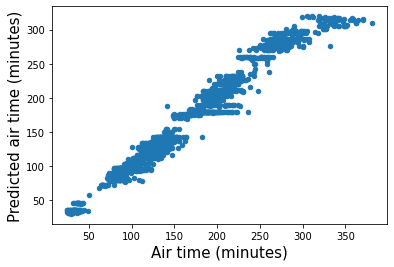

In [100]:
df_reg.plot(kind = 'scatter', x = 'air_time', y = 'prediction');

plt.xlabel('Air time (minutes)', fontsize = 15)
plt.ylabel('Predicted air time (minutes)', fontsize = 15);